**IMPLEMENTATION OF DEXINED MODEL FOR EDGE DETECTION FOR VARIOUS PLANT DATASETS (i.e. LETTUCE, BASIL)**



In [1]:
## requirements
import torch
import torch.nn as nn
import torch.nn.functional as F
import time, platform
import argparse
# import torchgeometry as tgm
import os
from glob import glob
import time, platform
import random
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from  torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler,autocast
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import pickle
import numpy as np

Defining Dexined Model Architecture.

In [2]:
def weight_init(m):
    if isinstance(m, (nn.Conv2d,)):
        # print("Applying custom weight initialization for nn.Conv2d layer...")
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, mean=0.0,)
        if m.weight.data.shape == torch.Size([1, 6, 1, 1]):
            torch.nn.init.constant_(m.weight, 0.2) # for fuse conv
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

    # for fusion layer
    if isinstance(m, (nn.ConvTranspose2d,)):
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, std=0.1)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

class CoFusion(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(CoFusion, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3,
                               stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3,
                               stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, out_ch, kernel_size=3,
                               stride=1, padding=1)
        self.relu = nn.ReLU()

        self.norm_layer1 = nn.GroupNorm(4, 64)
        self.norm_layer2 = nn.GroupNorm(4, 64)

    def forward(self, x):
        # fusecat = torch.cat(x, dim=1)
        attn = self.relu(self.norm_layer1(self.conv1(x)))
        attn = self.relu(self.norm_layer2(self.conv2(attn)))
        attn = F.softmax(self.conv3(attn), dim=1)

        # return ((fusecat * attn).sum(1)).unsqueeze(1)
        return ((x * attn).sum(1)).unsqueeze(1)

In [3]:
## defining blocks of dexined architecture
class _DenseLayer(nn.Sequential):
    def __init__(self, input_features, out_features):
        super(_DenseLayer, self).__init__()

        # self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(input_features, out_features,
                                           kernel_size=1, stride=1, padding=1, bias=True)),  #use any config (1)kernel_size=1, stride=1, padding=1; (2)kernel_size=3, stride=1, padding=2
        self.add_module('norm1', nn.BatchNorm2d(out_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(out_features, out_features,
                                           kernel_size=3, stride=1, bias=True)),
        self.add_module('norm2', nn.BatchNorm2d(out_features))
        # double check the norm1 comment if necessary and put norm after conv2

    def forward(self, x):
        x1, x2 = x

        new_features = super(_DenseLayer, self).forward(F.relu(x1))  # F.relu()
        # if new_features.shape[-1]!=x2.shape[-1]:
        #     new_features =F.interpolate(new_features,size=(x2.shape[2],x2.shape[-1]), mode='bicubic',
        #                                 align_corners=False)
        return 0.5 * (new_features + x2), x2

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, input_features, out_features):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(input_features, out_features)
            self.add_module('denselayer%d' % (i + 1), layer)
            input_features = out_features

# class SqueezeExcitation(nn.Module):
#     def __init__(self, nb_channels, reduction=16):
#         super(SqueezeExcitation, self).__init__()
#         self.nb_channels=nb_channels
#         self.avg_pool=nn.AdaptiveAvgPool2d(1)
#         self.fc=nn.Sequential(
#                 nn.Linear(nb_channels, nb_channels // reduction),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(nb_channels // reduction, nb_channels),
#                 nn.Sigmoid())

        
#     def forward(self, x):
#         y = self.avg_pool(x).view(-1,self.nb_channels)
#         y = self.fc(y).view(-1,self.nb_channels,1,1)
#         return x * y

class UpConvBlock(nn.Module):
    def __init__(self, in_features, up_scale):
        super(UpConvBlock, self).__init__()
        self.up_factor = 2
        self.constant_features = 16

        layers = self.make_deconv_layers(in_features, up_scale)
        assert layers is not None, layers
        self.features = nn.Sequential(*layers)

    def make_deconv_layers(self, in_features, up_scale):
        layers = []
        all_pads=[0,0,1,3,7]
        for i in range(up_scale):
            kernel_size = 2 ** up_scale
            pad = all_pads[up_scale]  # kernel_size-1
            out_features = self.compute_out_features(i, up_scale)
            layers.append(nn.Conv2d(in_features, out_features, 1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.ConvTranspose2d(
                out_features, out_features, kernel_size, stride=2, padding=pad))
            in_features = out_features
        return layers

    def compute_out_features(self, idx, up_scale):
        return 1 if idx == up_scale - 1 else self.constant_features

    def forward(self, x):
        return self.features(x)

class SingleConvBlock(nn.Module):
    def __init__(self, in_features, out_features, stride,
                 use_bs=True
                 ):
        super(SingleConvBlock, self).__init__()
        self.use_bn = use_bs
        self.conv = nn.Conv2d(in_features, out_features, 1, stride=stride,
                              bias=True)
        self.bn = nn.BatchNorm2d(out_features)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        return x


class DoubleConvBlock(nn.Module):
    def __init__(self, in_features, mid_features,
                 out_features=None,
                 stride=1,
                 use_act=True):
        super(DoubleConvBlock, self).__init__()

        self.use_act = use_act
        if out_features is None:
            out_features = mid_features
        self.conv1 = nn.Conv2d(in_features, mid_features,
                               3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(mid_features)
        self.conv2 = nn.Conv2d(mid_features, out_features, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_act:
            x = self.relu(x)
        return x

In [4]:
class DexiNed(nn.Module):
    """ Definition of the DXtrem network. """

    def __init__(self):
        super(DexiNed, self).__init__()
        self.block_1 = DoubleConvBlock(3, 32, 64, stride=2,)
        self.block_2 = DoubleConvBlock(64, 128, use_act=False)
        self.dblock_3 = _DenseBlock(2, 128, 256)
        self.dblock_4 = _DenseBlock(3, 256, 512)
        self.dblock_5 = _DenseBlock(3, 512, 512)
        self.dblock_6 = _DenseBlock(3, 512, 256)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # left skip connections, figure in Journal
        self.side_1 = SingleConvBlock(64, 128, 2)
        self.side_2 = SingleConvBlock(128, 256, 2)
        self.side_3 = SingleConvBlock(256, 512, 2)
        self.side_4 = SingleConvBlock(512, 512, 1)
        self.side_5 = SingleConvBlock(512, 256, 1)

        # right skip connections, figure in Journal
        self.pre_dense_2 = SingleConvBlock(128, 256, 2, use_bs=False)
        self.pre_dense_3 = SingleConvBlock(128, 256, 1)
        self.pre_dense_4 = SingleConvBlock(256, 512, 1)
        self.pre_dense_5_0 = SingleConvBlock(256, 512, 2,use_bs=False)
        self.pre_dense_5 = SingleConvBlock(512, 512, 1)
        self.pre_dense_6 = SingleConvBlock(512, 256, 1)

        # USNet
        self.up_block_1 = UpConvBlock(64, 1)
        self.up_block_2 = UpConvBlock(128, 1)
        self.up_block_3 = UpConvBlock(256, 2)
        self.up_block_4 = UpConvBlock(512, 3)
        self.up_block_5 = UpConvBlock(512, 4)
        self.up_block_6 = UpConvBlock(256, 4)
        # self.block_cat = SingleConvBlock(6, 1, stride=1, use_bs=False)  #hed fusion method
        self.block_cat = CoFusion(6,6)# cats fusion method

        self.apply(weight_init)

    def slice(self, tensor, slice_shape):
        t_shape = tensor.shape
        height, width = slice_shape
        if t_shape[-1]!=slice_shape[-1]:
            new_tensor = F.interpolate(
                tensor, size=(height, width), mode='bicubic',align_corners=False)
        else:
            new_tensor=tensor
        # tensor[..., :height, :width]
        return new_tensor

    def forward(self, x):
        assert x.ndim == 4, x.shape

        # Block 1
        # print(f"x shape           : {x.shape}")
        block_1 = self.block_1(x)
        # print(f"block_1 shape     : {block_1.shape}")
        block_1_side = self.side_1(block_1)
        # print(f"block_1_side shape: {block_1_side.shape}")

        # Block 2
        block_2 = self.block_2(block_1)
        block_2_down = self.maxpool(block_2)
        block_2_add = block_2_down + block_1_side
        block_2_side = self.side_2(block_2_add)

        # Block 3
        block_3_pre_dense = self.pre_dense_3(block_2_down)
        block_3, _ = self.dblock_3([block_2_add, block_3_pre_dense])
        block_3_down = self.maxpool(block_3)
        block_3_add = block_3_down + block_2_side
        block_3_side = self.side_3(block_3_add)

        # Block 4
        block_4_pre_dense_256 = self.pre_dense_2(block_2_down)
        block_4_pre_dense = self.pre_dense_4(
            block_4_pre_dense_256 + block_3_down)
        block_4, _ = self.dblock_4([block_3_add, block_4_pre_dense])
        block_4_down = self.maxpool(block_4)
        block_4_add = block_4_down + block_3_side
        block_4_side = self.side_4(block_4_add)

        # Block 5
        block_5_pre_dense_512 = self.pre_dense_5_0(block_4_pre_dense_256)
        block_5_pre_dense = self.pre_dense_5(
            block_5_pre_dense_512 + block_4_down)
        block_5, _ = self.dblock_5([block_4_add, block_5_pre_dense])
        block_5_add = block_5 + block_4_side

        # Block 6
        block_6_pre_dense = self.pre_dense_6(block_5)
        block_6, _ = self.dblock_6([block_5_add, block_6_pre_dense])

        # upsampling blocks
        # height, width = x.shape[-2:]
        # slice_shape = (height, width)
        # out_1 = self.slice(self.up_block_1(block_1), slice_shape)
        out_1 = self.up_block_1(block_1)
        out_2 = self.up_block_2(block_2)
        out_3 = self.up_block_3(block_3)
        out_4 = self.up_block_4(block_4)
        out_5 = self.up_block_5(block_5)
        out_6 = self.up_block_6(block_6)
        results = [out_1, out_2, out_3, out_4, out_5, out_6]
        # print(out_1.shape,out_2.shape,out_3.shape,out_4.shape,out_5.shape,out_6.shape)
        # print(results.shape)

        # concatenate multiscale outputs
        block_cat = torch.cat(results, dim=1)  # Bx6xHxW
        block_cat = self.block_cat(block_cat)  # Bx1xHxW
        
        # return results
        results.append(block_cat)
        return results


In [11]:
from torch.utils.data import Dataset
import cv2
### function which gets call with dataloader and it returns the patches
class plant_dataset(Dataset):
  def __init__(self, img_ids, patch_count):
    self.img_ids = img_ids
    self.patch_count = patch_count
    # self.mask = mask

  def __getitem__(self, index):
    img_id = self.img_ids[index]
    all_img_patch, all_mask_patch = transform(img_id)
    random_index = random.sample(range(0,len(all_img_patch)),self.patch_count)
    final_img = [all_img_patch[i] for i in random_index]
    final_mask = [all_mask_patch[i] for i in random_index]

    return final_img, final_mask
  
  def __len__(self):
    return len(self.img_ids)

Data augmentation methods

In [5]:
def standardize(img):
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    return img

def change_brightness(img):
    value = random.sample(range(-15,25),1)[0]
    # print(value) 
    hsv = (cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

def change_hue_intensity(img):
  value = random.sample(range(0,30),1)[0]
  r,g,b = cv2.split(img)
  if value%2==0:
    r=r+value
    r[r>255]=255
  else:
    b=b+value
    b[b>255] = 255
  return cv2.merge((r,g,b))

def change_blur(img):
  l = [1,3]
  index = random.sample(range(0,len(l)),1)[0]
  value = l[index]
  sigma = random.sample(range(0,5),1)[0]
  # print(value, sigma)
  return cv2.GaussianBlur(img, (value,value),sigma)

def color_balance(img):
  b, g, r = cv2.split(img)
  r_avg = cv2.mean(r)[0]
  g_avg = cv2.mean(g)[0]
  b_avg = cv2.mean(b)[0]
  
  # Find the gain of each channel
  k = (r_avg + g_avg + b_avg) / 3
  kr = k / r_avg
  kg = k / g_avg
  kb = k / b_avg
  
  r = cv2.addWeighted(src1=r, alpha=kr, src2=0, beta=0, gamma=0)
  g = cv2.addWeighted(src1=g, alpha=kg, src2=0, beta=0, gamma=0)
  b = cv2.addWeighted(src1=b, alpha=kb, src2=0, beta=0, gamma=0)
  
  balance_img = cv2.merge([b, g, r])
  return balance_img

Transform function called by plant_dataset function.

In [21]:
def transform(img_id):
    all_img = []
    all_mask = []
    mask_dir_list = ['/content/drive/MyDrive/basil_leaves/annotations_edge_jpg/',
                     '/content/drive/MyDrive/NC_state_hemp/annotations_filled/']
    mask_dir = mask_dir_list[0]
    # img_id = img_dir + id_img[id][45:]
    mask_id = mask_dir + img_id.split('/')[-1][:-4] + '_masked.jpg'  #[-38:-4]
    img = cv2.imread(img_id)
    img = color_balance(img)
    # print(img.shape)
    # img = remove_vignette(img)           ## for using vignette
    if img.shape== (1944, 2592, 3):  #(1944, 2592, 3), (3120, 4192, 3)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      # img = cv2.merge([img,img,img])
      mask = cv2.imread(mask_id)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      ret, mask = cv2.threshold(mask, 127, 255, 0)
      
      # img = img[:,192:] #[152:,32:]  ## Since majority of instances in a mask are not marked at the top region
      # mask = mask[:,192:] #[152:,32:] ## so cropping their top region to improve model performance
      img = cv2.resize(img, (2400,2000))
      mask = cv2.resize(mask, (2400,2000))
      # print(img_id)
      for i in range(6):    #1,9 15
        for j in range(5):  #1,6 9                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img_c = img[j*row:(j+1)*row,i*col:(i+1)*col] #[j*243:(j+1)*243,i*324:(i+1)*324]#[j*486:(j+1)*486,i*648:(i+1)*648]     ## than resized to (270,270) and finally included in a list if its mask contains  
          mask_c = mask[j*row:(j+1)*row,i*col:(i+1)*col]
          mask_c = mask_c.reshape(mask_c.shape[0], mask_c.shape[1], 1)
          if mask_c.max()==255:
            img_c = change_brightness(img_c)
            # img_c = change_hue_intensity(img_c)
            img_c = change_blur(img_c)
            # print(img_c.shape, mask_c.shape)
            if random.random() > 0.5:
                img_c = np.flipud(img_c) #TF.hflip(img_c)
                mask_c = np.flipud(mask_c) #TF.hflip(mask_c)

            if random.random() > 0.5:
                img_c = np.fliplr(img_c) #TF.vflip(img_c)
                mask_c = np.fliplr(mask_c) #TF.vflip(mask_c)

            # print(img_c.dtype)
            img_c = img_c.transpose(2,0,1)
            img_norm = img_c/255
            mask_c = mask_c.transpose(2,0,1)
            mask_norm = mask_c/255
            p_img = torch.from_numpy(img_norm).type(torch.float16)  #torch.FloatTensor
            p_mask = torch.from_numpy(mask_norm).type(torch.float16)
            all_img.append(p_img)
            all_mask.append(p_mask)

    return all_img,all_mask

Initialize dataloader for train and val dataset.

In [17]:
from torch.utils.data import DataLoader

def get_loaders(train_id, val_id, batchsize, patch_count):
  train_set = plant_dataset(train_id, patch_count)
  val_set = plant_dataset(val_id, patch_count)
  # print(len(train_set), len(val_set))
  dataloaders = {}
  dataloaders['train'] = DataLoader(train_set, batch_size=batchsize, shuffle = True, num_workers=0)
  dataloaders['val'] = DataLoader(val_set, batch_size=batchsize, shuffle = True, num_workers=0)

  return dataloaders

In [8]:
### discarded images from basil dataset which have incorrect annotation
discard = ['2008RR000131AB-2020-11-30T13-11-06.jpg',
 '2008RR000131AB-2020-12-12T08-11-05.jpg',
 '2008RR000131AB-2020-12-05T21-11-06.jpg',
 '2008RR000131AB-2020-12-12T11-11-07.jpg',
 '2008RR000131AB-2020-12-06T03-11-06.jpg',
 '2008RR000131AB-2020-11-28T00-11-07.jpg',
 '2008RR000131AB-2020-12-13T03-11-07.jpg',
 '2008RR000131AB-2020-12-06T08-11-06.jpg',
 '2008RR000131AB-2020-11-26T16-11-06.jpg',
 '2008RR000131AB-2020-12-06T11-11-06.jpg',
 '2008RR000131AB-2020-12-12T22-11-06.jpg',
 '2008RR000131AB-2020-12-13T05-11-06.jpg',
 '2008RR000131AB-2020-12-12T03-11-06.jpg',
 '2008RR000131AB-2020-12-10T12-11-06.jpg',
 '2008RR000131AB-2020-12-12T17-11-06.jpg',
 '2008RR000131AB-2020-12-06T05-11-07.jpg',
 '2008RR000131AB-2020-11-27T03-11-06.jpg',
 '2008RR000131AB-2020-11-30T12-11-07.jpg',
 '2008RR000131AB-2020-12-12T09-11-06.jpg',
 '2008RR000131AB-2020-11-27T17-11-07.jpg',
 '2008RR000131AB-2020-12-13T02-11-06.jpg',
 '2008RR000131AB-2020-12-12T10-11-07.jpg',
 '2008RR000131AB-2020-12-05T20-11-07.jpg',
 '2008RR000131AB-2020-12-06T02-11-06.jpg',
 '2008RR000131AB-2020-12-06T09-11-06.jpg',
 '2008RR000131AB-2020-11-27T05-11-07.jpg',
 '2008RR000131AB-2020-11-26T22-11-06.jpg',
 '2008RR000131AB-2020-11-30T14-11-07.jpg',
 '2008RR000131AB-2020-11-30T21-11-06.jpg',
 '2008RR000131AB-2020-12-05T13-11-06.jpg',
 '2008RR000131AB-2020-12-13T01-11-08.jpg',
 '2008RR000131AB-2020-12-12T16-11-06.jpg',
 '2008RR000131AB-2020-11-27T08-11-06.jpg',
 '2008RR000131AB-2020-11-26T17-11-05.jpg',
 '2008RR000131AB-2020-12-06T10-11-07.jpg',
 '2008RR000131AB-2020-12-13T04-11-06.jpg',
 '2008RR000131AB-2020-12-12T02-11-06.jpg',
 '2008RR000131AB-2020-12-12T13-11-07.jpg',
 '2008RR000131AB-2020-12-01T01-11-06.jpg',
 '2008RR000131AB-2020-12-06T01-11-06.jpg',
 '2008RR000131AB-2020-12-05T16-11-06.jpg',
 '2008RR000131AB-2020-12-10T09-11-06.jpg',
 '2008RR000131AB-2020-12-12T18-11-07.jpg',
 '2008RR000131AB-2020-11-26T19-11-06.jpg',
 '2008RR000131AB-2020-12-12T01-11-06.jpg',
 '2008RR000131AB-2020-11-26T21-11-05.jpg',
 '2008RR000131AB-2020-12-12T15-11-07.jpg',
 '2008RR000131AB-2020-12-12T20-11-06.jpg',
 '2008RR000131AB-2020-12-06T13-11-06.jpg',
 '2008RR000131AB-2020-12-01T00-11-06.jpg',
 '2008RR000131AB-2020-12-06T00-11-06.jpg',
 '2008RR000131AB-2020-12-05T22-11-06.jpg',
 '2008RR000131AB-2020-12-12T12-11-06.jpg',
 '2008RR000131AB-2020-12-13T00-11-06.jpg',
 '2008RR000131AB-2020-12-12T19-11-06.jpg',
 '2008RR000131AB-2020-11-26T15-11-07.jpg',
 '2008RR000131AB-2020-11-26T20-11-06.jpg',
 '2008RR000131AB-2020-11-30T16-11-06.jpg',
 '2008RR000131AB-2020-12-06T06-11-07.jpg',
 '2008RR000131AB-2020-12-06T12-11-07.jpg',
 '2008RR000131AB-2020-11-26T18-11-06.jpg',
 '2008RR000131AB-2020-12-12T00-11-06.jpg',
 '2008RR000131AB-2020-12-12T21-11-06.jpg',
 '2008RR000131AB-2020-12-12T14-11-07.jpg']

In [ ]:
# for basil (creating random ids for train and val dataset)
id_img=[]
path1 = '/content/drive/MyDrive/basil_leaves/images-1/'
path2 = '/content/drive/MyDrive/basil_leaves/images-2/'
path3 = '/content/drive/MyDrive/basil_leaves/Basil-overlapping-annotations/'
path4 = '/content/drive/MyDrive/basil_leaves/Basil_Polygon_26-March_1stFolder/'
path5 = '/content/drive/MyDrive/basil_leaves/Basil_Polygon_26-March_2ndFolder/'
# images1 = os.listdir(path1)
# images2 = os.listdir(path2)
images1 = glob(path1+'*.jpg')
images2 = glob(path2+'*.jpg')
images3 = glob(path3+'*.jpg')
images4 = glob(path4+'*.jpg')
images5 = glob(path5+'*.jpg')
remove_img3 = '/content/drive/MyDrive/basil_leaves/Basil-overlapping-annotations/2008RR000133AB-2020-12-16T09-13-06.jpg'
img3 = [images3[i] for i in range(len(images3)) if images3[i] not in remove_img3]
remove_img5 = '/content/drive/MyDrive/basil_leaves/Basil_Polygon_26-March_2ndFolder/2008RR000136AB-2021-01-18T07-16-05.jpg'
img5 = [images5[i] for i in range(len(images5)) if images5[i] not in remove_img5]
[id_img.append(i) for i in (images1)]
[id_img.append(i) for i in (images2)]
[id_img.append(i) for i in (img3)]
[id_img.append(i) for i in (images4)]
[id_img.append(i) for i in (img5)]
id_img = [id_img[i] for i in range(len(id_img)) if id_img[i][-38:] not in discard]
random.shuffle(id_img)
# len(id_img)
train_set = id_img[:687]
val_set = id_img[687:816]
test_set = id_img[816:-1]

print('No. train dataset: {}, No. validation dataset: {}, No. of test dataset: {}'.format(len(train_set),len(val_set),len(test_set)))

# writing the ids of loading images

# with open("/content/drive/MyDrive/basil_leaves/pickle_train_val_test_file/train(1)_687.txt", "wb") as fp:   #Pickling
#   pickle.dump(train_set, fp)
# with open("/content/drive/MyDrive/basil_leaves/pickle_train_val_test_file/val(1)_129.txt", "wb") as fp:   #Pickling
#   pickle.dump(val_set, fp)
# with open("/content/drive/MyDrive/basil_leaves/pickle_train_val_test_file/test(1)_43.txt", "wb") as fp:   #Pickling
#   pickle.dump(test_set, fp)


In [ ]:
# for lettuce (creating random ids for train and val dataset)
id_img=[]
path1 = '/content/drive/MyDrive/lettuce_data/Lettuce1_15 Feb/'
images1 = glob(path1+'*.jpg')
[id_img.append(i) for i in (images1)]
random.shuffle(id_img)
# len(id_img)

train_set = id_img[:215]
val_set = id_img[215:-1]
test_set = id_img[215:-1]

print('No. train dataset: {}, No. validation dataset: {}, No. of test dataset: {}'.format(len(train_set),len(val_set),len(test_set)))

# writing the ids of loading images

# with open("/content/drive/MyDrive/lettuce_data/pickle_train_val_test_file/train(1)_215.txt", "wb") as fp:   #Pickling
#   pickle.dump(train_set, fp)
# with open("/content/drive/MyDrive/lettuce_data/pickle_train_val_test_file/val(1)_29.txt", "wb") as fp:   #Pickling
#   pickle.dump(val_set, fp)
# with open("/content/drive/MyDrive/lettuce_data/pickle_train_val_test_file/test(1)_29(same_val).txt", "wb") as fp:   #Pickling
#   pickle.dump(test_set, fp)


In [ ]:
# for NC_state hemp (creating random ids for train and val dataset)
id_img=[]
path1 = '/content/drive/MyDrive/NC_state_hemp/Cannabis-01-04-2021-47Images/'
images1 = glob(path1+'*.jpg')
path2 = '/content/drive/MyDrive/NC_state_hemp/Cannabis_30-3-2021-74images/'
images2 = glob(path2+'*.jpg')
path3 = '/content/drive/MyDrive/NC_state_hemp/Cannabis-07-04-2021-70images/'
images3 = glob(path3+'*.jpg')

# print(len(distorted_shape))
[id_img.append(i) for i in (images1)]
[id_img.append(i) for i in (images2)]
[id_img.append(i) for i in (images3)]
distorted_shape = []
for i in range(len(id_img)):
    # print(i, images1[i])
    img = cv2.imread(id_img[i])
    if img.shape != (3120, 4192, 3):
      distorted_shape.append(id_img[i])
id_img = [id_img[i] for i in range(len(id_img)) if id_img[i] not in distorted_shape]
random.shuffle(id_img)
# len(id_img)

train_set = id_img[:145]
val_set = id_img[145:-1]
test_set = id_img[145:-1]

print('No. train dataset: {}, No. validation dataset: {}, No. of test dataset: {}'.format(len(train_set),len(val_set),len(test_set)))

# writing the ids of loading images
# out_dir = '/content/drive/MyDrive/NC_state_hemp/pickle_train_val_test_file/'
# if not os.path.isdir(out_dir):
#     os.mkdir(out_dir)

# with open("/content/drive/MyDrive/NC_state_hemp/pickle_train_val_test_file/train(1)_145.txt", "wb") as fp:   #Pickling
#   pickle.dump(train_set, fp)
# with open("/content/drive/MyDrive/NC_state_hemp/pickle_train_val_test_file/val(1)_25.txt", "wb") as fp:   #Pickling
#   pickle.dump(val_set, fp)
# with open("/content/drive/MyDrive/NC_state_hemp/pickle_train_val_test_file/test(1)_25(same_val).txt", "wb") as fp:   #Pickling
#   pickle.dump(test_set, fp)

Load the above created .txt file for necessary dataset(lettuce or hemp or basil)

In [18]:
with open("/content/drive/MyDrive/basil_leaves/pickle_train_val_test_file/train(1)_687.txt", "rb") as fp:   # Unpickling
  train_id = pickle.load(fp)
with open("/content/drive/MyDrive/basil_leaves/pickle_train_val_test_file/val(1)_129.txt", "rb") as fp:   # Unpickling
  val_id = pickle.load(fp)
with open("/content/drive/MyDrive/basil_leaves/pickle_train_val_test_file/test(1)_43.txt", "rb") as fp:   # Unpickling
  test_id = pickle.load(fp)

print('No. train dataset: {}, No. validation dataset: {}, No. of test dataset: {}'.format(len(train_id),len(val_id),len(test_id)))

No. train dataset: 687, No. validation dataset: 129, No. of test dataset: 41


In [22]:
## call get_loaders function
loaders = get_loaders(train_id, val_id,2,2)
print(len(loaders['train']), len(loaders['val']))

344 65


Visualization of dataloader

float32 float32


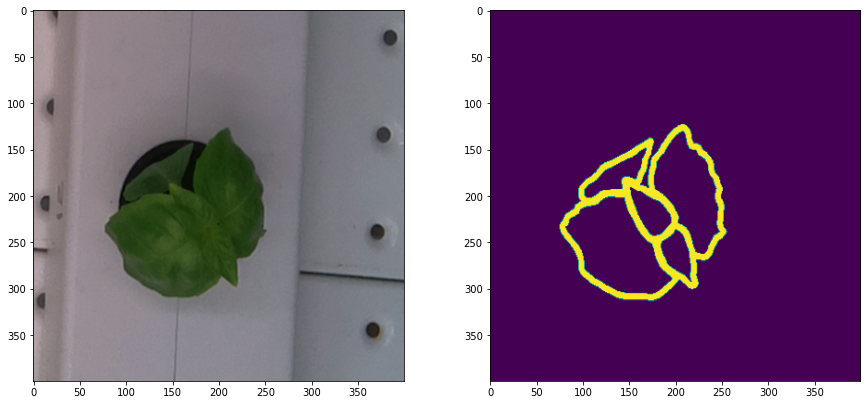

In [23]:
img, mask = next(iter(loaders['train']))
img = torch.cat(img, dim=0)
mask = torch.cat(mask, dim=0)
img=list(img)
mask=list(mask)
i=3
img_ex = (img[i].numpy().transpose((1,2,0))).astype(np.float32)
mask_ex = (mask[i].numpy().transpose((1,2,0)).squeeze()).astype(np.float32)
print(img_ex.dtype, mask_ex.dtype)
plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img_ex)
plt.subplot(222), plt.imshow(mask_ex)
plt.show()

Functions neccessary to train the model with float16 precision.

In [ ]:
def prep_param_lists(model, flat_master=False):
  model_params = [param for param in model.parameters() if param.requires_grad]
  # if flat_master:

  #     # ignore for now
  # else:
  master_params = [param.clone().float().detach() for param in model_params]
  for param in master_params:
    param.requires_grad = True
  return model_params, master_params

def model_grads_to_master_grads(model_params, master_params, flat_master=False):
    # if flat_master:
    #     # ignore for now
    # else:
    for model, master in zip(model_params, master_params):
        if model.grad is not None:
            if master.grad is None:
                master.grad = Variable(master.data.new(*master.data.size()))
            master.grad.data.copy_(model.grad.data)
        else:
          master.grad = None

def master_params_to_model_params(model_params, master_params, flat_master=False):
    if flat_master:
        for model, master in zip(model_params, 
                                 _unflatten_dense_tensors(master_params[0].data, model_params)):
            model.data.copy_(master)
    else:
        for model, master in zip(model_params, master_params):
            model.data.copy_(master.data)


In [ ]:
def bdcn_loss(inputs, targets, l_weight=1.1):
    # [0.5,0.5,0.5,0.5,0.5,0.5,1.1]
    # inputs = inputs.float()
    # targets = targets.float()
    mask = (targets > 0.).float()
    b, c, h, w = mask.shape
    pos = torch.sum(mask, dim=[1, 2, 3], keepdim=True).float()
    weight = torch.zeros_like(mask)  # Shape: [b,].
    neg = c * h * w - pos
    # print(mask.dtype, pos.dtype, weight.dtype, neg.dtype)
    weight.masked_scatter_(targets > 0., torch.ones_like(targets) * (neg * 1. / (pos + neg)))
    weight.masked_scatter_(targets <= 0., torch.ones_like(targets) * (pos * 1.1 / (pos + neg)))
    # weights[i, t == 1] = neg * 1. / valid
    # weights[i, t == 0] = pos * balance / valid
    # weights = torch.Tensor(weights)
    # print(mask.dtype, weight.dtype)

    inputs = torch.sigmoid(inputs)
    # loss = nn.BCELoss(weight, size_average=False)(inputs, targets)
    loss =  torch.nn.BCEWithLogitsLoss(weight, reduction='sum')(inputs, targets) #torch.nn.BCELoss(weight, reduction='sum')(inputs, targets)
    # loss = F.binary_cross_entropy(inputs, targets,weight)
    # loss = F.binary_cross_entropy_with_logits(inputs, targets, weight=weight)
    return (l_weight*loss)

def dice_coef(y_pred, y_mask):
  y_pred_prob = torch.sigmoid(y_pred)
  y_pred_prob = (y_pred_prob > 0.5).float()    ## 0.5 is threshold taken and is a hyperparameter which changes dice coeff
  y_pred_prob_f = y_pred_prob.view(-1)
  y_mask_f = y_mask.view(-1)
  intersection = torch.sum(y_pred_prob_f*y_mask_f)
  union = torch.sum(y_pred_prob_f) + torch.sum(y_mask_f)
  if torch.sum(y_pred_prob_f)==0 and torch.sum(y_mask_f)==0:
    return 1.0

  return (2*intersection/union)

def dice_coef0(y_pred, y_mask):
  y_pred_prob = torch.sigmoid(y_pred)
  y_pred_prob = (y_pred_prob > 0.0).float()    ## 0.0 is threshold taken and is a hyperparameter which changes dice coeff
  y_pred_prob_f = y_pred_prob.view(-1)
  y_mask_f = y_mask.view(-1)
  intersection = torch.sum(y_pred_prob_f*y_mask_f)
  union = torch.sum(y_pred_prob_f) + torch.sum(y_mask_f)
  if torch.sum(y_pred_prob_f)==0 and torch.sum(y_mask_f)==0:
    return 1.0

  return (2*intersection/union)

def dice_coef7(y_pred, y_mask):
  y_pred_prob = torch.sigmoid(y_pred)
  y_pred_prob = (y_pred_prob > 0.7).float()    ## 0.7 is threshold taken and is a hyperparameter which changes dice coeff
  y_pred_prob_f = y_pred_prob.view(-1)
  y_mask_f = y_mask.view(-1)
  intersection = torch.sum(y_pred_prob_f*y_mask_f)
  union = torch.sum(y_pred_prob_f) + torch.sum(y_mask_f)
  if torch.sum(y_pred_prob_f)==0 and torch.sum(y_mask_f)==0:
    return 1.0

  return (2*intersection/union)

def dice_coef3(y_pred, y_mask):
  y_pred_prob = torch.sigmoid(y_pred)
  y_pred_prob = (y_pred_prob > 0.3).float()    ## 0.3 is threshold taken and is a hyperparameter which changes dice coeff
  y_pred_prob_f = y_pred_prob.view(-1)
  y_mask_f = y_mask.view(-1)
  intersection = torch.sum(y_pred_prob_f*y_mask_f)
  union = torch.sum(y_pred_prob_f) + torch.sum(y_mask_f)
  if torch.sum(y_pred_prob_f)==0 and torch.sum(y_mask_f)==0:
    return 1.0

  return (2*intersection/union)

Function to train and val for single epoch in float16

In [ ]:
# '''
def train_one_epoch(epoch, scaler, dataloader, model, model_params, master_params, criterion, optimizer, device):
    model.train()
    l_weight = [0.7,0.7,1.1,1.1,0.3,0.3,1.3] #[0.5,0.5,0.5,0.5,0.5,0.5,1.1]

    for batch_id, (img,mask) in enumerate(dataloader):
        img = torch.cat(img, dim=0)
        mask = torch.cat(mask, dim=0)
        model.zero_grad()
        img = img.view(-1,3,400,400).to(device)  # BxCxHxW
        mask = mask.view(-1,1,400,400).to(device)  # BxHxW

        preds_list = model(img)
        loss = sum([criterion(preds.float(), mask.float(),l_w) for preds, l_w in zip(preds_list,l_weight)])  #.float()
        scaler.scale(loss).backward()
        
        # scaled_loss = (sfactor * loss.float())
        # scaled_loss.backward()

        model_grads_to_master_grads(model_params, master_params)
        # for param in master_params:
        #   param.grad.data.mul_(1./sfactor)

        scaler.step(optimizer)  #optimizer.step()
        scaler.update()
        master_params_to_model_params(model_params, master_params)

        if batch_id % 200 == 0:
            print('Epoch: {0} Sample {1}/{2} Loss: {3}'
                  .format(epoch, batch_id, len(dataloader), loss.item()))

def validate_one_epoch(epoch, scaler, dataloader, model, model_params, master_params, criterion, optimizer, device):
    dice_coeff0=0
    dice_coeff3=0
    dice_coeff5=0
    dice_coeff7=0
    model.eval()
    l_weight = [0.7,0.7,1.1,1.1,0.3,0.3,1.3] #[0.5,0.5,0.5,0.5,0.5,0.5,1.1]
    with torch.no_grad():
        for batch_id, (img,mask) in enumerate(dataloader):
            img = torch.cat(img, dim=0)
            mask = torch.cat(mask, dim=0)
            img = img.view(-1,3,400,400).to(device)  # BxCxHxW
            mask = mask.view(-1,1,400,400).to(device)  # BxHxW

            preds_list = model(img)
            loss = sum([criterion(preds.float(), mask.float(),l_w) for preds, l_w in zip(preds_list,l_weight)])
            # scaled_loss = (sfactor * loss.float())
            dice_coeff0 += dice_coef0(preds_list[-1].float(), mask.float())
            dice_coeff3 += dice_coef3(preds_list[-1].float(), mask.float())
            dice_coeff5 += dice_coef(preds_list[-1].float(), mask.float())
            dice_coeff7 += dice_coef7(preds_list[-1].float(), mask.float())
            if batch_id % 100 == 0:
                print('Epoch: {0} Sample {1}/{2} Loss: {3}'
                    .format(epoch, batch_id, len(dataloader), loss.item()))
    total_len = (img.size(0)*len(dataloader))
    return dice_coeff0/total_len, dice_coeff3/total_len, dice_coeff5/total_len, dice_coeff7/total_len

# '''

Define the model and change its type to half-precision (except for batchnorm layers)

In [ ]:
## for apex
device = "cuda"
model = DexiNed().to(device)
# checkpoint_path = '/content/drive/My Drive/basil_leaves/new1_dexined_epoch30+30+30_dc_0.331_fixeddataset.pth'
# model.load_state_dict(torch.load(checkpoint_path))

model = model.half()  # convert to half precision
## batchnorm layer should be in float32 else the gradient overflow or underflow problem might occur
for layer in model.modules():
  if isinstance(layer, nn.BatchNorm2d):
    layer.float()

Start the training

In [ ]:
model_params, master_params = prep_param_lists(model)

optimizer = optim.Adam(master_params, lr=0.0005, weight_decay = 0.0001) #, weight_decay = 0.0001
# print(optimizer.param_groups[0]['params'][0].dtype)
criterion = bdcn_loss
scaler = GradScaler()
epochs=30
for epoch in range(epochs):
  train_one_epoch(epoch, scaler, loaders['train'], model, model_params, master_params, criterion, optimizer, device)
  d0,d3,d5,d7 = validate_one_epoch(epoch, scaler, loaders['val'], model, model_params, master_params, criterion, optimizer, device)
  print('dice_coef0: {:.6f}, dice_coef3: {:.6f}, dice_coef5: {:.6f}, dice_coef7: {:.6f}'.format(d0,d3,d5,d7))

# '''

Save the trained model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/NC_state_hemp/dexined_plant_seg_0.30.pth')

Training is completed. Now testing the model

In [24]:
import numpy as np

def image_normalization(img, img_min=0, img_max=255,epsilon=1e-12):
    img = np.float32(img)
    # whenever an inconsistent image
    img = (img - np.min(img)) * (img_max - img_min) / \
        ((np.max(img) - np.min(img)) + epsilon) + img_min
    return img  
  

def save_image_batch_to_disk(tensor,emp_mask):
    t=0
    tensor = torch.sigmoid(tensor) #.type(torch.float32)
    tensor = (tensor>0.5).float()
    tensor = tensor.cpu().numpy()
    emp_mask = emp_mask.squeeze()
    for i in range(6):    # 10
        for j in range(5):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img = tensor[t].transpose(1,2,0).squeeze()
          emp_mask[j*row:(j+1)*row,i*col:(i+1)*col] = cv2.bitwise_or(img, emp_mask[j*row:(j+1)*row,i*col:(i+1)*col], mask = None)
          t=t+1
    emp_mask = cv2.resize(emp_mask, (2592,1944))
    return emp_mask

Below the functions are created to in a way to test the single image at a time.

In [25]:
from torch.utils.data import Dataset
import cv2

def transform_single(id):
    all_img = []
    img = cv2.imread(id)
    img = color_balance(img)
    if img.shape== (1944, 2592, 3):
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (2400,2000))           ## Since majority of instances in a mask are not marked at the top region
      # img = cv2.resize(img, (2560,1792))
      # print(img)
      mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)          ## so cropping their top region to improve model performance
      mask = mask.reshape(mask.shape[0],mask.shape[1],1)
      # print(mask.shape)
      emp_mask = np.zeros(mask.shape, dtype=np.float32)
      # print(id, ' ', id_img[id])
      for i in range(6):    # 10
        for j in range(5):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img_c = img[j*row:(j+1)*row,i*col:(i+1)*col] #[j*243:(j+1)*243,i*324:(i+1)*324]#[j*486:(j+1)*486,i*648:(i+1)*648]     ## than resized to (270,270) and finally included in a list if its mask contains  
          img_c = img_c.transpose(2,0,1)
          img_norm = img_c/255
          p_img = torch.from_numpy(img_norm).type(torch.FloatTensor) #FloatTensor
          all_img.append(p_img)
         
    return all_img, emp_mask

class plant_dataset(Dataset):
  def __init__(self, img):
    self.img = img
    # self.mask = mask

  def __getitem__(self, index):
    img_id = self.img[index]
    # mask_id = self.mask[index]
    return img_id
  
  def __len__(self):
    return len(self.img)


In [29]:
def test_single(test_loader, model, device, emp_mask):
    # Put model in evaluation mode
    model.eval()
    all_pred = []
    all_img = []
    # img = img_ins
    with torch.no_grad():
        for batch_id, (img) in enumerate(test_loader):
          # print(img.shape)
          img = img.view(-1,3,400,400).to(device)  #img.view(-1,3,256,256).to(device)   
          preds = model(img)[-1]
          # print(preds.shape)
          add_mask = save_image_batch_to_disk(preds, emp_mask)

    print('Testing finished')
    return preds, add_mask


Load the model with previous saved checkpoints.

In [27]:
weights = ['new_dexined_epoch10_dc_0.034_fixeddataset_without_anything.pth',
           'new_dexined_epoch30_dc_0.042_fixeddataset_without_blur.pth',
           'new_dexined_epoch40_dc_0.041_fixeddataset.pth',
           'new_dexined_epoch20_dc_0.039_fixeddataset_without_hue&blur.pth',
           'new_dexined_epoch20+30_dc_0.081_fixeddataset_without_blur.pth',
           'new_dexined_epoch40_dc_0.165_fixeddataset_without_blur.pth',
           'new_dexined_epoch30_dc_top_fixeddataset.pth',
           'new_dexined_epoch30_dc_0.323_fixeddataset.pth',
           'new1_dexined_epoch30+30+30_dc_0.331_fixeddataset.pth',
           'new1_dexined_epoch30+30+30+30_dc_0.335_fixeddataset.pth'
           ]

checkpoint_path = '/content/drive/My Drive/basil_leaves/new1_dexined_epoch30+30+30+30_dc_0.335_fixeddataset.pth' 
device='cuda'
model = DexiNed().to(device)
if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file note found: {checkpoint_path}")
print(f"Restoring weights from: {checkpoint_path}")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

Restoring weights from: /content/drive/My Drive/basil_leaves/new1_dexined_epoch30+30+30+30_dc_0.335_fixeddataset.pth


<All keys matched successfully>

Test the single image

In [56]:
start = time()
## id of image for testing
id = test_id[11] ##provide id of image to be tested
all_img, emp_mask = transform_single(id)
test_set = plant_dataset(all_img)
test_loader = DataLoader(test_set, batch_size = 30, shuffle = False)  #batch_size = 70
# out_pred,out_img = test_single(checkpoint_path, loaders['val'], model, device, output_dir)
# start = time()
out_pred,add_mask = test_single(test_loader, model, device, emp_mask)
end = time()

Testing finished


VISUALIZATION #1

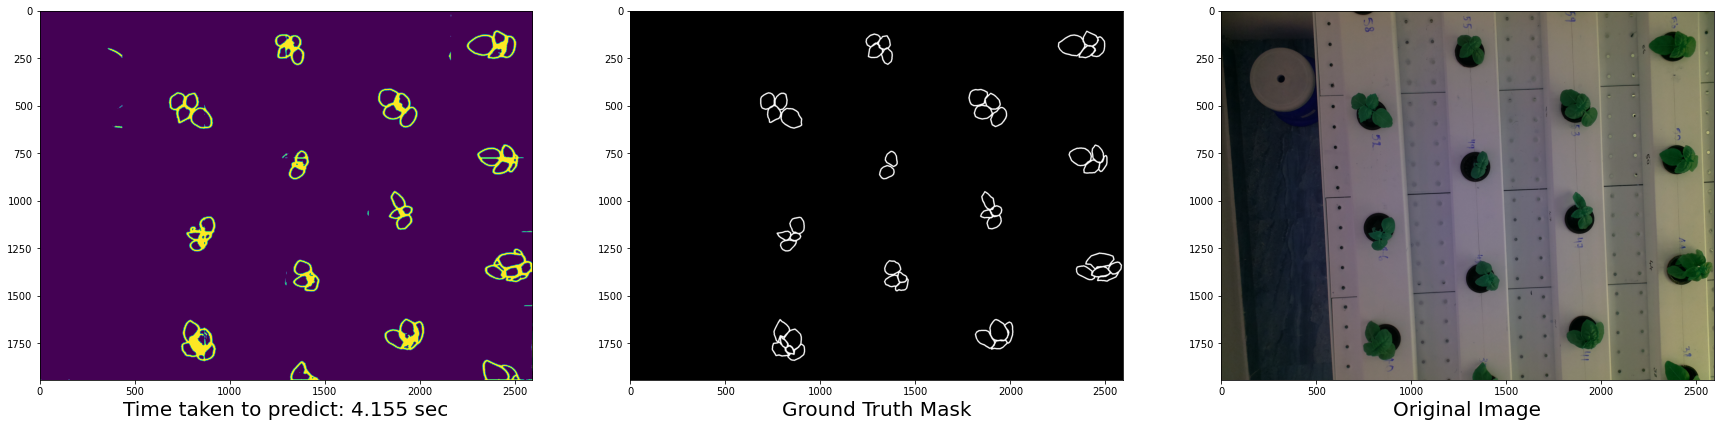

In [55]:
import matplotlib.pyplot as plt
test_img = cv2.imread(id)
gt_dir = ['/content/drive/MyDrive/NC_state_hemp/annotations_filled/',
          '/content/drive/MyDrive/basil_leaves/annotations_edge_jpg/']
gt_dir = gt_dir[-1]
gt_mask_id = gt_dir + id.split('/')[-1][:-4] + '_masked.jpg'
gt_mask = cv2.imread(gt_mask_id)
plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(add_mask)
plt.xlabel('Time taken to predict: {:.3f} sec'.format((end-start)), fontsize=20)
plt.subplot(132), plt.imshow(gt_mask)
plt.xlabel('Ground Truth Mask', fontsize=20)
plt.subplot(133), plt.imshow(test_img)
plt.xlabel('Original Image', fontsize=20)

plt.show()

VISUALIZATION #2

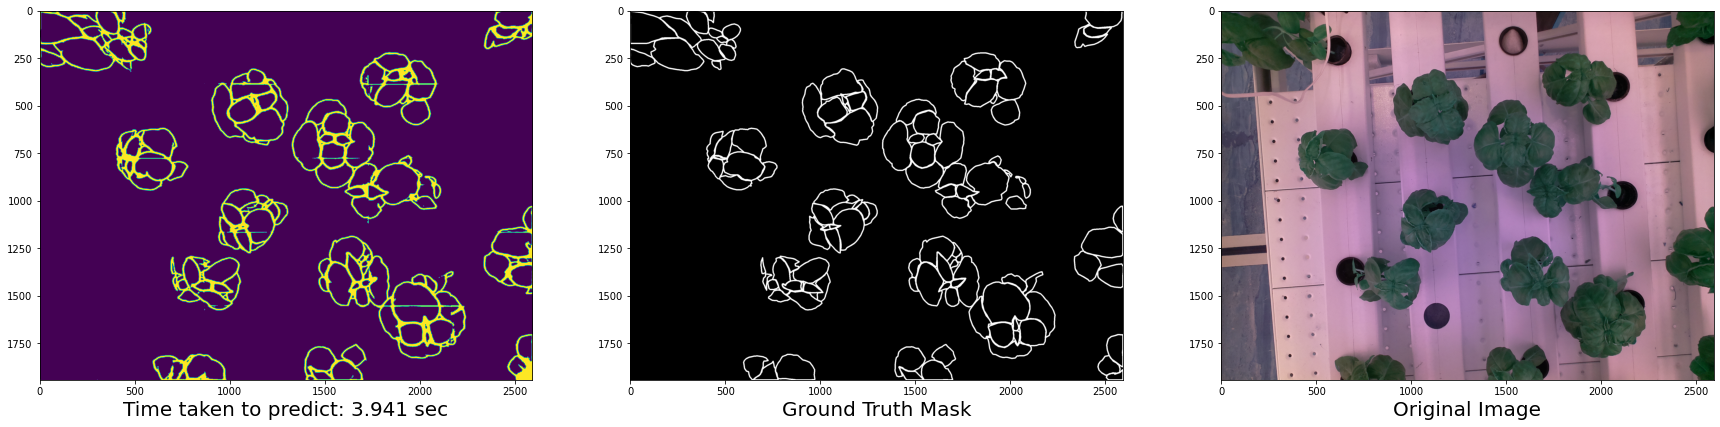

In [57]:
import matplotlib.pyplot as plt
test_img = cv2.imread(id)
gt_dir = ['/content/drive/MyDrive/NC_state_hemp/annotations_filled/',
          '/content/drive/MyDrive/basil_leaves/annotations_edge_jpg/']
gt_dir = gt_dir[-1]
gt_mask_id = gt_dir + id.split('/')[-1][:-4] + '_masked.jpg'
gt_mask = cv2.imread(gt_mask_id)
plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(add_mask)
plt.xlabel('Time taken to predict: {:.3f} sec'.format((end-start)), fontsize=20)
plt.subplot(132), plt.imshow(gt_mask)
plt.xlabel('Ground Truth Mask', fontsize=20)
plt.subplot(133), plt.imshow(test_img)
plt.xlabel('Original Image', fontsize=20)

plt.show()